In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sturdr.dsp.acquisition import SerialSearch, PcpsSearch, Peak2NoiseFloorComparison, Peak2PeakComparison
from sturdr.channel.gps_l1ca_channel import gps_l1ca_code
from sturdr.utils.rf_data_buffer import RfDataBuffer
from sturdr.dsp.gnss_signal import CodeNCO


# config
prn = 7
in_file = '../rfdata/class_ifen_8bit_20e6_if_5000445.88565834.bin'
sampling_freq = 20e6
carrier_freq = 1575.42e6
code_freq = 1.023e6
intermediate_freq = 5000445.88565834
is_complex = False
bit_depth = 8
method = 'pcps'
test = 'peak2noisefloor'
doppler_range = 5000
doppler_step = 500
coherent_integration = 1
noncoherent_integration = 5
threshold = 10.0
samples_per_ms = int(sampling_freq * 1e-3)

In [2]:
# Load Configuration
signal_file = RfDataBuffer(in_file, sampling_freq, is_complex, bit_depth)

# Read specified amount of data from signal file
rfdata = signal_file.fread(coherent_integration * noncoherent_integration * samples_per_ms)

# Create GPS L1 C/A Code replica
code = gps_l1ca_code(prn)
code_len = code.size

In [3]:
# Try acquisition
dt = 0.001
if method == 'serial':
    correlation_map = SerialSearch(rfdata, 
                                   code, 
                                   doppler_range, 
                                   doppler_step, 
                                   sampling_freq, 
                                   code_freq, 
                                   intermediate_freq)
    y = np.linspace(0,code_len,2*code_len)
    r = 0.5
else:
    code_upsampled,_ = CodeNCO(code, sampling_freq, code_freq, code_len)
    correlation_map = PcpsSearch(rfdata, 
                                   code_upsampled, 
                                   doppler_range, 
                                   doppler_step, 
                                   sampling_freq, 
                                   intermediate_freq, 
                                   coherent_integration, 
                                   noncoherent_integration)
    y = np.linspace(0,1023,20000)
    r = code_len/(dt*sampling_freq)

# Test against threshold
if test == 'peak2noisefloor':
    first_peak_idx, acquisition_metric = Peak2NoiseFloorComparison(correlation_map)
else:
    first_peak_idx, acquisition_metric = Peak2PeakComparison(
        correlation_map, dt*sampling_freq, np.round(dt*sampling_freq/code_len))

In [4]:
# Print results
x = np.arange(-doppler_range, doppler_range+1, doppler_step)
print(f"Doppler: {x[first_peak_idx[0]]}")
print(f"Code: {first_peak_idx[1]*r} chips, {first_peak_idx[1]} samples")
print(f"Metric: {acquisition_metric}")
print(f"Success: {acquisition_metric > threshold}")

Doppler: -500
Code: 988.47375 chips, 19325 samples
Metric: 89.53498944849851
Success: True


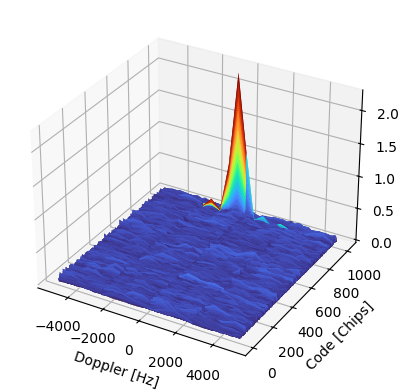

In [5]:
# Display Results
x,y = np.meshgrid(x,y)
plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel("Doppler [Hz]")
ax.set_ylabel("Code [Chips]")
ax.plot_surface(x, y, correlation_map.T, 
                rstride=1, cstride=5, 
                cmap=plt.get_cmap('turbo'))
plt.show()